# Тестовое задание

## 1. Импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import precision_score, recall_score, auc, accuracy_score, roc_auc_score,\
classification_report, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

## 2. Загружаем данные
### Легенда
* Gender - Пол 
* Age - Возраст 
* Income - Доход 
* Flag - Целевая переменная 

In [2]:
df = pd.read_excel('Data-1.xlsx', skiprows=[1])

In [3]:
df[:5]

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,NaN,Female,49,30000,0,NaN,NaN,NaN
1,NaN,Male,38,135000,0,NaN,NaN,NaN
2,NaN,Male,41,70000,0,NaN,NaN,NaN
3,NaN,Female,27,127000,0,NaN,NaN,NaN
4,NaN,Male,52,125000,0,NaN,NaN,NaN


## 3. Обрабатываем данные

In [4]:
df.drop(
    labels=['Unnamed: 0', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7'],
    axis=1,
    inplace=True,
)

In [5]:
df = df.rename(
    columns={
        'Unnamed: 1': 'Gender',
        'Unnamed: 2': 'Age',
        'Unnamed: 3': 'Income',
        'Unnamed: 4': 'Flag'
    })

In [6]:
df['Gender'].replace(['Female', 'Male'], [0, 1], inplace=True)

In [7]:
#### one-hot encoding - приведем категориальный признак к числовому

## 4. EDA

## Гипотезы
1. Чем выше доход, тем выше вероятность флага
2. Чем больше возраст, тем ниже вероятность выпадения флага

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Gender  40000 non-null  int64
 1   Age     40000 non-null  int64
 2   Income  40000 non-null  int64
 3   Flag    40000 non-null  int64
dtypes: int64(4)
memory usage: 1.2 MB


#### Пропущенных значений - нет

In [9]:
df.shape

(40000, 4)

In [10]:
df.head() 

,Gender,Age,Income,Flag
0,0,49,30000,0
1,1,38,135000,0
2,1,41,70000,0
3,0,27,127000,0
4,1,52,125000,0


In [11]:
df.describe()

,Gender,Age,Income,Flag
count,40000.000000,40000.000000,40000.000000,40000.000000
mean,0.506525,40.046050,109766.500000,0.324425
std,0.499964,8.933391,51968.813212,0.468165
min,0.000000,25.000000,20000.000000,0.000000
25%,0.000000,32.000000,65000.000000,0.000000
50%,1.000000,40.000000,110000.000000,0.000000
75%,1.000000,48.000000,154000.000000,1.000000
max,1.000000,55.000000,200000.000000,1.000000


#### Явных выбросов - не обнаружено

## 4.1 Корреляция признаков

<AxesSubplot:>

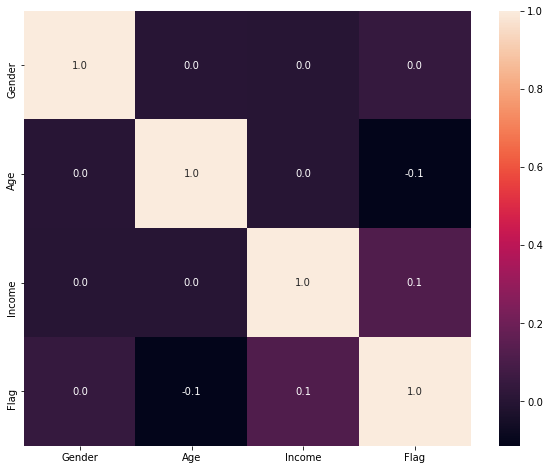

In [12]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(method='spearman'), annot=True, fmt=".1f")

#### Присутствует корреляция между возрастом, доходом и целевой переменной
#### На основании этих признаков мы можем обучить модель

## 4.2 Распределение признаков Income и Age 

<AxesSubplot:ylabel='Frequency'>

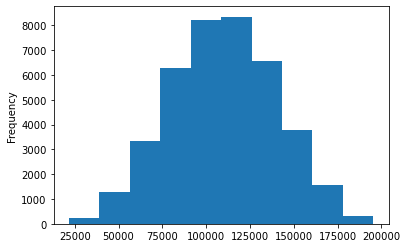

In [13]:
df.Income.rolling(3).mean().plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

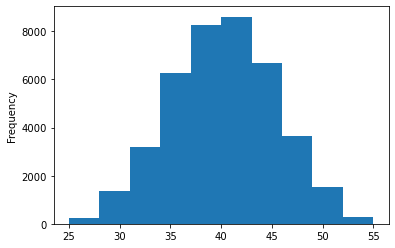

In [14]:
df.Age.rolling(3).mean().plot(kind='hist')

### Признаки распределенны нормально

## 4.3 Распределение целевой переменной Flag

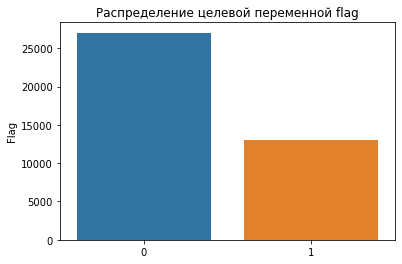

In [15]:
sns.barplot(y=df.Flag.value_counts(),x=df.Flag.unique())
plt.title('Распределение целевой переменной flag');

### В данном наборе данных присутствует дисбаланс классов

## 4.4 Признак Age

### Плотность распределения для  признака Age

(array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ]),
 [Text(0, 0.0, '0.000'),
  Text(0, 0.005, '0.005'),
  Text(0, 0.01, '0.010'),
  Text(0, 0.015, '0.015'),
  Text(0, 0.02, '0.020'),
  Text(0, 0.025, '0.025'),
  Text(0, 0.03, '0.030'),
  Text(0, 0.035, '0.035'),
  Text(0, 0.04, '0.040')])

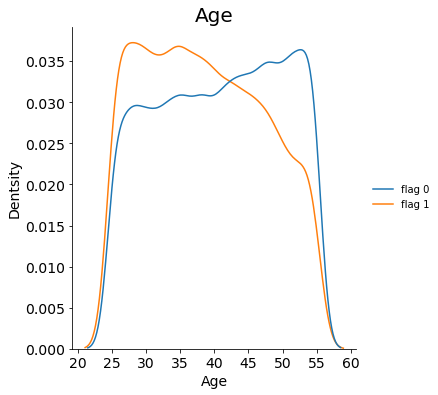

In [16]:
sns.displot(
    {
        "flag 0": df[df.Flag == 0].Age,
        "flag 1": df[df.Flag == 1].Age
    },
    kind="kde",
    common_norm=False 
)

plt.title('Age', fontsize=20)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Dentsity', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

### Отношение среднего и медианы признака Age к целевой перменной

In [17]:
df.groupby('Flag')['Age'].median()

Flag
0    41
1    38
Name: Age, dtype: int64

In [18]:
df.groupby('Flag')['Age'].mean()

Flag
0    40.749473
1    38.581259
Name: Age, dtype: float64

## 4.5 Признак Income

### Плотность распределения для  признака Income

(array([0.e+00, 1.e-06, 2.e-06, 3.e-06, 4.e-06, 5.e-06, 6.e-06, 7.e-06]),
 [Text(0, 0.0, '0'),
  Text(0, 1e-06, '1'),
  Text(0, 2e-06, '2'),
  Text(0, 3e-06, '3'),
  Text(0, 4e-06, '4'),
  Text(0, 4.9999999999999996e-06, '5'),
  Text(0, 6e-06, '6'),
  Text(0, 7e-06, '7')])

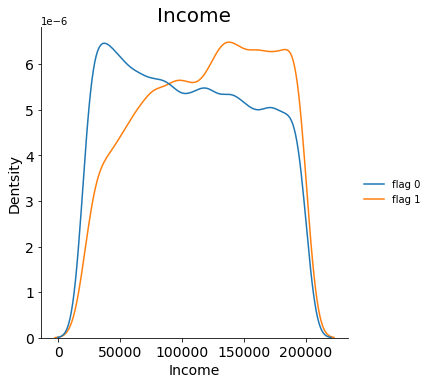

In [19]:
sns.displot(
    {
        "flag 0": df[df.Flag == 0].Income,
        "flag 1": df[df.Flag == 1].Income
    },
    kind="kde",
    common_norm=False)

plt.title('Income', fontsize=20)
plt.xlabel('Income', fontsize=14)
plt.ylabel('Dentsity', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

### Отношение среднего и медианы признака Income к целевой перменной

In [20]:
df.groupby('Flag')['Income'].median()

Flag
0    104000
1    122000
Name: Income, dtype: int64

In [21]:
df.groupby('Flag')['Income'].mean()

Flag
0    105488.620804
1    118674.655159
Name: Income, dtype: float64

### Гипотезы 1 и 2 подтвердились

## 5. Построение модели

### Для решения задач бинарной классификации c малым количеством признаков уместно использовать модели на основе деревьев решений 

##### Поскольку у деревьев решений:

##### * быстрый процесс обучения
##### * генерация правил в областях, где трудно формализовать свои знания
##### * извлечение правил на естественном языке
##### * возможность визуализировать классификационную модель
##### * высокая точность прогноза, сопоставимая с другими методами

In [22]:
X = df.drop(columns=['Flag', 'Gender'], axis=1)
y = df['Flag'].values

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    stratify=y,
                                                    shuffle=True,
                                                    random_state=0)

In [24]:
tree = DecisionTreeClassifier(max_depth=15,
                              random_state=0,
                              class_weight='balanced')
tree.fit(X, y)
y_pred = tree.predict(X_test)
y_score = tree.predict_proba(X_test)[:,1]

## 6. Метрики

#### * ROC AUC - в условиях дисбаланса классов ROC AUC является хорошей метрикой
#### * Precision - если нас больше интересуют ошибки I рода (важнее выдать кредит 'хорошему' заемщику, чем выдать 'плохому')
#### * Recall - если нас больше интересуют ошибки II рода (важнее не выдать кредит 'плохому' заемщику, чем не выдать 'хорошему')


![jupyter](https://miro.medium.com/max/888/1*7J08ekAwupLBegeUI8muHA.png)

In [25]:
metrics = pd.DataFrame(index=['roc-auc', 'precision', 'recall'])

metrics['Score'] = [
    roc_auc_score(y_test, y_score),
    precision_score(y_test, y_pred),
    recall_score(y_test, y_pred)
]

In [26]:
metrics

,Score
roc-auc,0.715083
precision,0.455736
recall,0.718866


## 6.1 Визуализируем ROC AUC

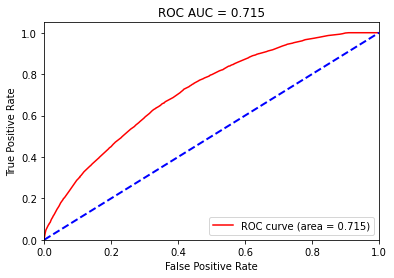

In [27]:
fpr, tpr, thresholds = roc_curve(y_test, y_score)

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='red', label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC AUC = %0.3f' % roc_auc)
plt.legend(loc="lower right")
plt.show()